# Upload data to Colab

In [0]:
import json
from pprint import pprint
from google.colab import auth
from googleapiclient.discovery import build
import io
from googleapiclient.http import MediaIoBaseDownload
import pickle

**You'll be prompted for your google credentials after running next cell**

In [0]:
auth.authenticate_user()
drive_service = build('drive', 'v3')

In [0]:
def _create_file_request(file_id):
    return drive_service.files().get_media(fileId=file_id)


def _download_response_bytes(request, print_progress=False):
    downloaded = io.BytesIO()
    downloader = MediaIoBaseDownload(downloaded, request)
    
    for status in _progbar(downloader):
        if print_progress:
            print("Downloaded {}/{} bytes".format(status.resumable_progress, status.total_size))
  
    downloaded.seek(0)
    return downloaded.read()

  
def _progbar(downloader):
    done = False
    while done is False:
        status, done = downloader.next_chunk()
        yield status


def get_file_id(name):
    return get_matching_files(name)[0]['id']


def move_from_drive_to_disk(file_names, file_destinations):
    for file_name, dest in zip(file_names, file_destinations):
        file_id = get_file_id(file_name)
        print('Downloading file: "{}"'.format(file_name))
        file_bytes = _download_response_bytes(_create_file_request(file_id), print_progress=True)
        with open(dest, "wb") as f:
            f.write(file_bytes)


def load_pickled_files(file_names):
    for name in file_names:
        yield pickle.load(open(name, "rb"))
        

def get_matching_files(name):
    drive_files_response = _download_response_bytes(drive_service.files().list())
    drive_files_response_dict = json.loads(
        drive_files_response.decode('utf-8')
    )
    drive_files_dict = drive_files_response_dict['files']
  
    matching_records = [
        record
        for record in drive_files_dict
        if record['name'] == name
    ]

    no_records = len(matching_records)
    if no_records == 0:
        raise ValueError('no such file: "{}" on your Google Drive'.format(name))
    elif no_records > 1:
        print('warning: multiple matches for file "{}"'.format(name))
    return matching_records

Assume you have file named `data.zip` on your google drive.

In [0]:
example_file_name = 'train_test_data.zip'
example_file_id = get_file_id(example_file_name)

In [0]:
move_from_drive_to_disk([example_file_name], ['train_test_data.zip'])

Downloaded 104857601/212781105 bytes
Downloaded 209715202/212781105 bytes
Downloaded 212781105/212781105 bytes


In [0]:
!unzip train_test_data.zip
!rm train_test_data.zip
!mv train_test_data data

Archive:  train_test_data.zip
   creating: train_test_data/
   creating: train_test_data/dt05_bth/
  inflating: train_test_data/dt05_bth/F01_050C0103_BTH.CH1.wav  
  inflating: train_test_data/dt05_bth/F01_050C0105_BTH.CH1.wav  
  inflating: train_test_data/dt05_bth/F01_050C010C_BTH.CH1.wav  
  inflating: train_test_data/dt05_bth/F01_050C010G_BTH.CH1.wav  
  inflating: train_test_data/dt05_bth/F01_050C010J_BTH.CH1.wav  
  inflating: train_test_data/dt05_bth/F01_050C010K_BTH.CH1.wav  
  inflating: train_test_data/dt05_bth/F01_050C010L_BTH.CH1.wav  
  inflating: train_test_data/dt05_bth/F01_050C010O_BTH.CH1.wav  
  inflating: train_test_data/dt05_bth/F01_050C010P_BTH.CH1.wav  
  inflating: train_test_data/dt05_bth/F01_050C010R_BTH.CH1.wav  
  inflating: train_test_data/dt05_bth/F01_050C010U_BTH.CH1.wav  
  inflating: train_test_data/dt05_bth/F01_050C010W_BTH.CH1.wav  
  inflating: train_test_data/dt05_bth/F01_050C0112_BTH.CH1.wav  
  inflating: train_test_data/dt05_bth/F01_050C0116_BTH.C

# Import libraries

In [1]:
%matplotlib inline

! pip install -q librosa nltk

import tensorflow as tf
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras
import matplotlib.pyplot as plt
import numpy as np
import librosa
import glob
from librosa.core import load, stft, magphase, istft
from librosa.output import write_wav

from keras import initializers, layers, models
from keras.utils.conv_utils import conv_output_length, deconv_length

plt.rcParams['figure.figsize'] = [20, 8]
plt.rcParams['image.cmap'] = 'hot'

Using TensorFlow backend.


# Functions

In [0]:
def extract_spectrogram_patches(spec, n_fft, patch_window, patch_hop):
    spec3d = np.expand_dims(spec, axis=0)
    spec4d = np.expand_dims(spec3d, axis=3)

    patches = tf.extract_image_patches(
        images=spec4d,
        ksizes=[1, patch_window, 1 + n_fft / 2, 1],
        strides=[1, patch_hop, 1 + n_fft / 2, 1],
        rates=[1, 1, 1, 1],
        padding='VALID'
    ).eval()

    num_patches = patches.shape[1]

    return np.reshape(patches, (num_patches, patch_window, int(1 + n_fft // 2), 1))

def roll(arr,shift):
    shape = arr.shape
    arr = arr.reshape(shape[0]*shape[1],shape[2],shape[3])
    arr = np.roll(arr, shift, axis=0)
    return arr.reshape(shape[0],shape[1],shape[2],shape[3])

In [0]:
def reverse_extract_spectrogram_patches(spec):
    spec2 = spec.reshape(1,-1,512,1)
    
    with tf.Session() as sess:
        patches = tf.extract_image_patches(
            images=spec2,
            ksizes=[1, 128, 512, 1],
            strides=[1, 256, 512, 1],
            rates=[1, 1, 1, 1],
            padding='VALID'
        ).eval()

    return np.concatenate((patches.reshape(1,-1,512,1), spec2[:,-128:,:,:]), axis=1)

# Preprocess data

In [0]:
def preprocess_training_data(
        mixed_pattern = '/content/data/dt05_bus_simu/F01*.wav',
        voice_pattern = '/content/data/dt05_bth/F01*.wav',
        sample_rate = 44100,
        n_fft = 1024,
        fft_hop = 256,
        patch_window = 256,
        patch_hop = 128,
):
    
    def extract_data(path):
        #Downloading data from an audio file
        audio, _ = librosa.load(path, sr=sample_rate, mono=True)
        #Converting audio data to a spectrogram (using the Window Fourier transform)
        spec = librosa.stft(audio, n_fft=n_fft, hop_length=fft_hop, window='hann')
        real = spec.real.T
        imag = spec.imag.T
        #increasing data and dividing into equal pieces
        # for example: a = ([1,2,3,4,5],[6,7,8,9,10],[11,12,13,14,15]) ->
        # a[0] = ([1,2,3,4,5],[6,7,8,9,10])
        # a[1] = ([6,7,8,9,10],[11,12,13,14,15])
        with tf.Session() as sess:
            real_patches = extract_spectrogram_patches(real, n_fft, patch_window, patch_hop)
            imag_patches = extract_spectrogram_patches(imag, n_fft, patch_window, patch_hop)
        real_patches = real_patches[:,:,:512,:]
        imag_patches = imag_patches[:,:,:512,:]
        
        return real_patches, imag_patches
    
    mixed_paths = sorted(glob.glob(mixed_pattern))
    voice_paths = sorted(glob.glob(voice_pattern))
    
    #creating a folder where training data will be stored
    newpath = r'/content/data/train_data' 
    if not os.path.exists(newpath):
        os.makedirs(newpath)
    
    if len(mixed_paths)==len(voice_paths):
        i=0
        for mixed_path, voice_path in zip(mixed_paths, voice_paths):
            mixed_real_patches, mixed_imag_patches = extract_data(mixed_path)
            voice_real_patches, voice_imag_patches = extract_data(voice_path)
            #applying bias to the voice, since the voice is initially obtained as biased
            voice_real_patches = roll(voice_real_patches,-4)
            voice_imag_patches = roll(voice_imag_patches,-4)
            
            mixed_patches = np.concatenate((mixed_real_patches, mixed_imag_patches), axis=1)
            voice_patches = np.concatenate((voice_real_patches, voice_imag_patches), axis=1)
            
            #saving processed data into train_data/
            for mixed_patch, voice_patch in zip(mixed_patches, voice_patches):
                np.savez(f'/content/data/train_data/{i}.npz', x=mixed_patch, y=voice_patch)
                #Applying normalization №1(
                '''
                mag_max=max(mixed_mag_patch.max(),voice_mag_patch.max())
                mixed_mag_patch=mixed_mag_patch/mag_max
                voice_mag_patch=voice_mag_patch/mag_max
                phase_max=max(mixed_phase_patch.max(),voice_phase_patch.max())
                mixed_phase_patch=mixed_phase_patch/phase_max
                voice_phase_patch=voice_phase_patch/phase_max
                '''
                #)
                
                i=i+1
    else:
        print("len(mixed_paths)!=len(voice_paths)")

preprocess_training_data()

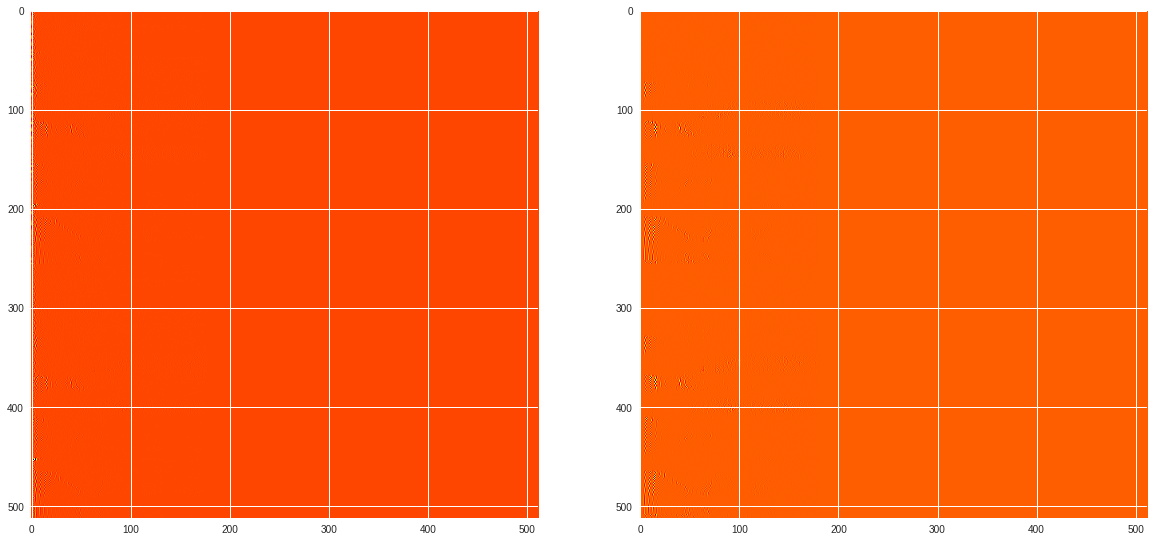

In [23]:
npz = np.load('/content/data/train_data/0.npz')

fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(20,20))
ax1.imshow(npz['x'][:, :, 0])
ax2.imshow(npz['y'][:, :, 0])

# Train model

**U-net model:**

In [0]:
input_size = (512, 512, 1)
inputs = Input(input_size)
conv1 = Conv2D(16, 5, strides=2, padding='same')(inputs)
conv1 = BatchNormalization()(conv1)
conv1 = LeakyReLU(alpha=0.2)(conv1)

conv2 = Conv2D(32, 5, strides=2, padding='same')(conv1)
conv2 = BatchNormalization()(conv2)
conv2 = LeakyReLU(alpha=0.2)(conv2)

conv3 = Conv2D(64, 5, strides=2, padding='same')(conv2)
conv3 = BatchNormalization()(conv3)
conv3 = LeakyReLU(alpha=0.2)(conv3)

conv4 = Conv2D(128, 5, strides=2, padding='same')(conv3)
conv4 = BatchNormalization()(conv4)
conv4 = LeakyReLU(alpha=0.2)(conv4)

conv5 = Conv2D(256, 5, strides=2, padding='same')(conv4)
conv5 = BatchNormalization()(conv5)
conv5 = LeakyReLU(alpha=0.2)(conv5)

conv6 = Conv2D(512, 5, strides=2, padding='same')(conv5)
conv6 = BatchNormalization()(conv6)
conv6 = LeakyReLU(alpha=0.2)(conv6)

deconv7 = Deconv2D(256, 5, strides=2, padding='same')(conv6)
deconv7 = BatchNormalization()(deconv7)
deconv7 = Dropout(0.5)(deconv7)
deconv7 = Activation('relu')(deconv7)

deconv8 = Concatenate(axis=3)([deconv7, conv5])
deconv8 = Deconv2D(128, 5, strides=2, padding='same')(deconv8)
deconv8 = BatchNormalization()(deconv8)
deconv8 = Dropout(0.5)(deconv8)
deconv8 = Activation('relu')(deconv8)

deconv9 = Concatenate(axis=3)([deconv8, conv4])
deconv9 = Deconv2D(64, 5, strides=2, padding='same')(deconv9)
deconv9 = BatchNormalization()(deconv9)
deconv9 = Dropout(0.5)(deconv9)
deconv9 = Activation('relu')(deconv9)

deconv10 = Concatenate(axis=3)([deconv9, conv3])
deconv10 = Deconv2D(32, 5, strides=2, padding='same')(deconv10)
deconv10 = BatchNormalization()(deconv10)
deconv10 = Activation('relu')(deconv10)

deconv11 = Concatenate(axis=3)([deconv10, conv2])
deconv11 = Deconv2D(16, 5, strides=2, padding='same')(deconv11)
deconv11 = BatchNormalization()(deconv11)
deconv11 = Activation('relu')(deconv11)

deconv12 = Concatenate(axis=3)([deconv11, conv1])
deconv12 = Deconv2D(1, 5, strides=2, padding='same')(deconv12)
deconv12 = Activation('relu')(deconv12)

model = Model(inputs=inputs, outputs=deconv12)

model.compile(optimizer=Adam(1e-4), loss='mean_absolute_error')

In [30]:
def generator():
    while 1:
        for npz_path in npz_paths:
            npz = np.load(npz_path)
            x = np.expand_dims(npz['x'], axis=0)
            y = np.expand_dims(npz['y'], axis=0)
            yield (x, y)

npz_paths = glob.glob('/content/data/train_data/*.npz')
model.fit_generator(generator(),len(npz_paths),epochs=5)

Epoch 1/5
785/785 [==============================] - 51s 65ms/step - loss: 0.1016
Epoch 2/5
785/785 [==============================] - 51s 65ms/step - loss: 0.1010
Epoch 3/5
785/785 [==============================] - 51s 65ms/step - loss: 0.1005
Epoch 4/5
785/785 [==============================] - 51s 65ms/step - loss: 0.1001
Epoch 5/5
785/785 [==============================] - 51s 64ms/step - loss: 0.0996


Uploading data for prediction

In [0]:
#audio, _ = librosa.load('/content/data/dt05_bus_simu/F01_050C0103_BUS.CH1.wav', sr=44100, mono=True)
audio, _ = librosa.load('/content/data/dt05_bus_real/F01_050C0105_BUS.CH1.wav', sr=44100, mono=True)
spec = librosa.stft(audio, n_fft=1024, hop_length=256, window='hann')
real = spec.real.T
imag = spec.imag.T
with tf.Session() as sess:
    real_patches = extract_spectrogram_patches(real, 1024, 256, 128)
    imag_patches = extract_spectrogram_patches(imag, 1024, 256, 128)
real_patches = real_patches[:,:,:512,:]
imag_patches = imag_patches[:,:,:512,:]
patches = np.concatenate((real_patches, imag_patches), axis=1)
#normalization
#norm=spectrogram.max()
#spectrogram=spectrogram/norm

Spectrogram: Before - After

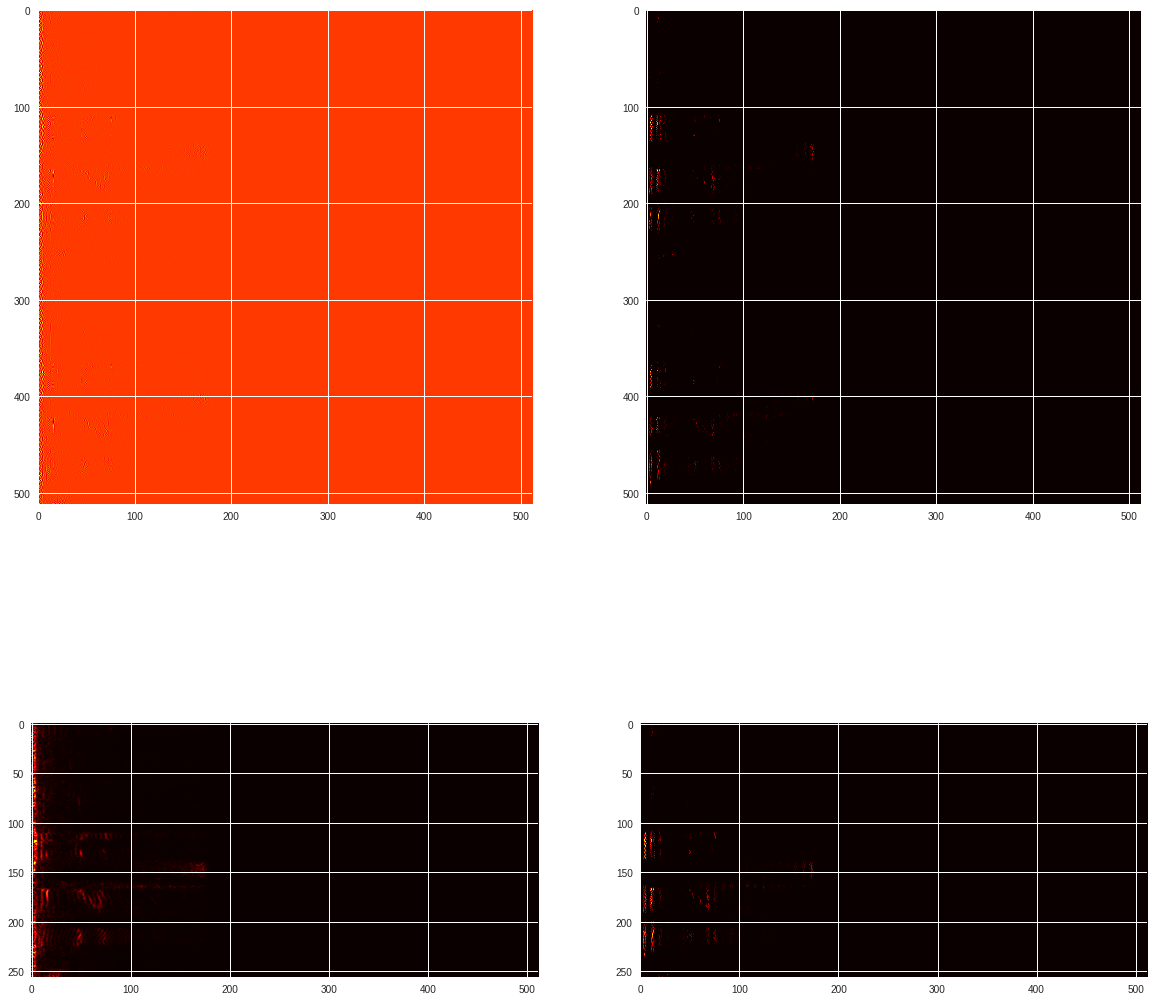

In [31]:
voice_spec = model.predict(patches)

fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2, 2, figsize=(20,20))
ax1.imshow(patches[0, :, :, 0])
ax2.imshow(voice_spec[0, :, :, 0])
ax3.imshow(np.abs(patches[0, :256, :, 0]+patches[0, 256:, :, 0]*1j))
ax4.imshow(np.abs(voice_spec[0, :256, :, 0]+voice_spec[0, 256:, :, 0]*1j))

Converting prediction back to file

In [0]:
spectrogram_r1 = reverse_extract_spectrogram_patches(voice_spec[:,:256,:,:])
spectrogram_r2 = reverse_extract_spectrogram_patches(voice_spec[:,256:,:,:])
spectrogram_r1 = spectrogram_r1[0,:,:,0].T
spectrogram_r2 = spectrogram_r2[0,:,:,0].T
spectrogram = spectrogram_r1+spectrogram_r2*1j
spectrogram = np.vstack((spectrogram, np.zeros((spectrogram.shape[1]))))
write_wav(f'test.wav', istft(spectrogram, win_length=1024, hop_length=256, window='hann'), 44100, norm=True)

# Test

In [19]:
audio, _ = librosa.load('/content/data/dt05_bus_simu/F01_050C0103_BUS.CH1.wav', sr=44100, mono=True)
spec = librosa.stft(audio, n_fft=1024, hop_length=256, window='hann')
print('spec')
print(spec.shape)
print(type(spec[0][0]))
print(spec)
print('spec')
print(spec.shape)
print(type((spec.real+spec.imag*1j)[0][0]))
print(spec.real+spec.imag*1j)
mag, phase = magphase(spec)
print('mag')
print(mag.shape)
print(type(mag[0][0]))
print(mag)
print('phase')
print(phase.shape)
print(type(phase[0][0]))
print(phase)
'''
mag = mag.T
print('mag')
print(mag.shape)
print(type(mag[0][0]))
print(mag)
with tf.Session() as sess:
    spectrogram = extract_spectrogram_patches(mag, 1024, 256, 128)
spectrogram = spectrogram[:,:,:512,:]
print('spectrogram')
print(spectrogram.shape)
print(type(spectrogram[0][0]))
'''
#print(spectrogram)
#нормализация
#norm=spectrogram.max()
#spectrogram=spectrogram/norm

spec
(513, 1075)
<class 'numpy.complex64'>
[[ 3.1856394e+00+0.0000000e+00j  1.8033552e+00+0.0000000e+00j
  -2.6348965e+00+0.0000000e+00j ...  2.3235359e+00+0.0000000e+00j
   5.5708942e+00+0.0000000e+00j  6.3485389e+00+0.0000000e+00j]
 [ 1.8912739e-01-7.8550447e-17j -3.4584339e+00-1.3088802e+00j
   3.1244543e+00-2.9936550e+00j ...  1.4466017e+00-5.6192271e-02j
  -4.5356855e+00+3.2702131e+00j -3.3578677e+00-2.6156247e+00j]
 [-5.6217468e-01-5.4868061e-17j  4.7355070e+00-3.0333326e+00j
  -6.7405901e+00+9.1360015e-01j ... -9.9223393e-01+6.4747059e-01j
   2.6416740e+00-5.8945789e+00j -3.2721558e+00+2.5305789e+00j]
 ...
 [-2.7697829e-03+6.5795269e-19j  1.3848401e-03-1.3191314e-07j
   8.6465661e-08+6.9831430e-08j ...  8.9224066e-08+3.4117225e-08j
   3.6111564e-05-9.7708609e-05j -3.1822620e-04+8.5652439e-04j]
 [ 2.7695885e-03+7.9688860e-18j -5.6485469e-08-1.3848128e-03j
  -6.4855740e-08-2.6061585e-08j ...  1.1750478e-08+2.8597075e-08j
   8.5691398e-05-5.9299706e-05j -5.2139180e-04-7.5035304e-04

"\nmag = mag.T\nprint('mag')\nprint(mag.shape)\nprint(type(mag[0][0]))\nprint(mag)\nwith tf.Session() as sess:\n    spectrogram = extract_spectrogram_patches(mag, 1024, 256, 128)\nspectrogram = spectrogram[:,:,:512,:]\nprint('spectrogram')\nprint(spectrogram.shape)\nprint(type(spectrogram[0][0]))\n"

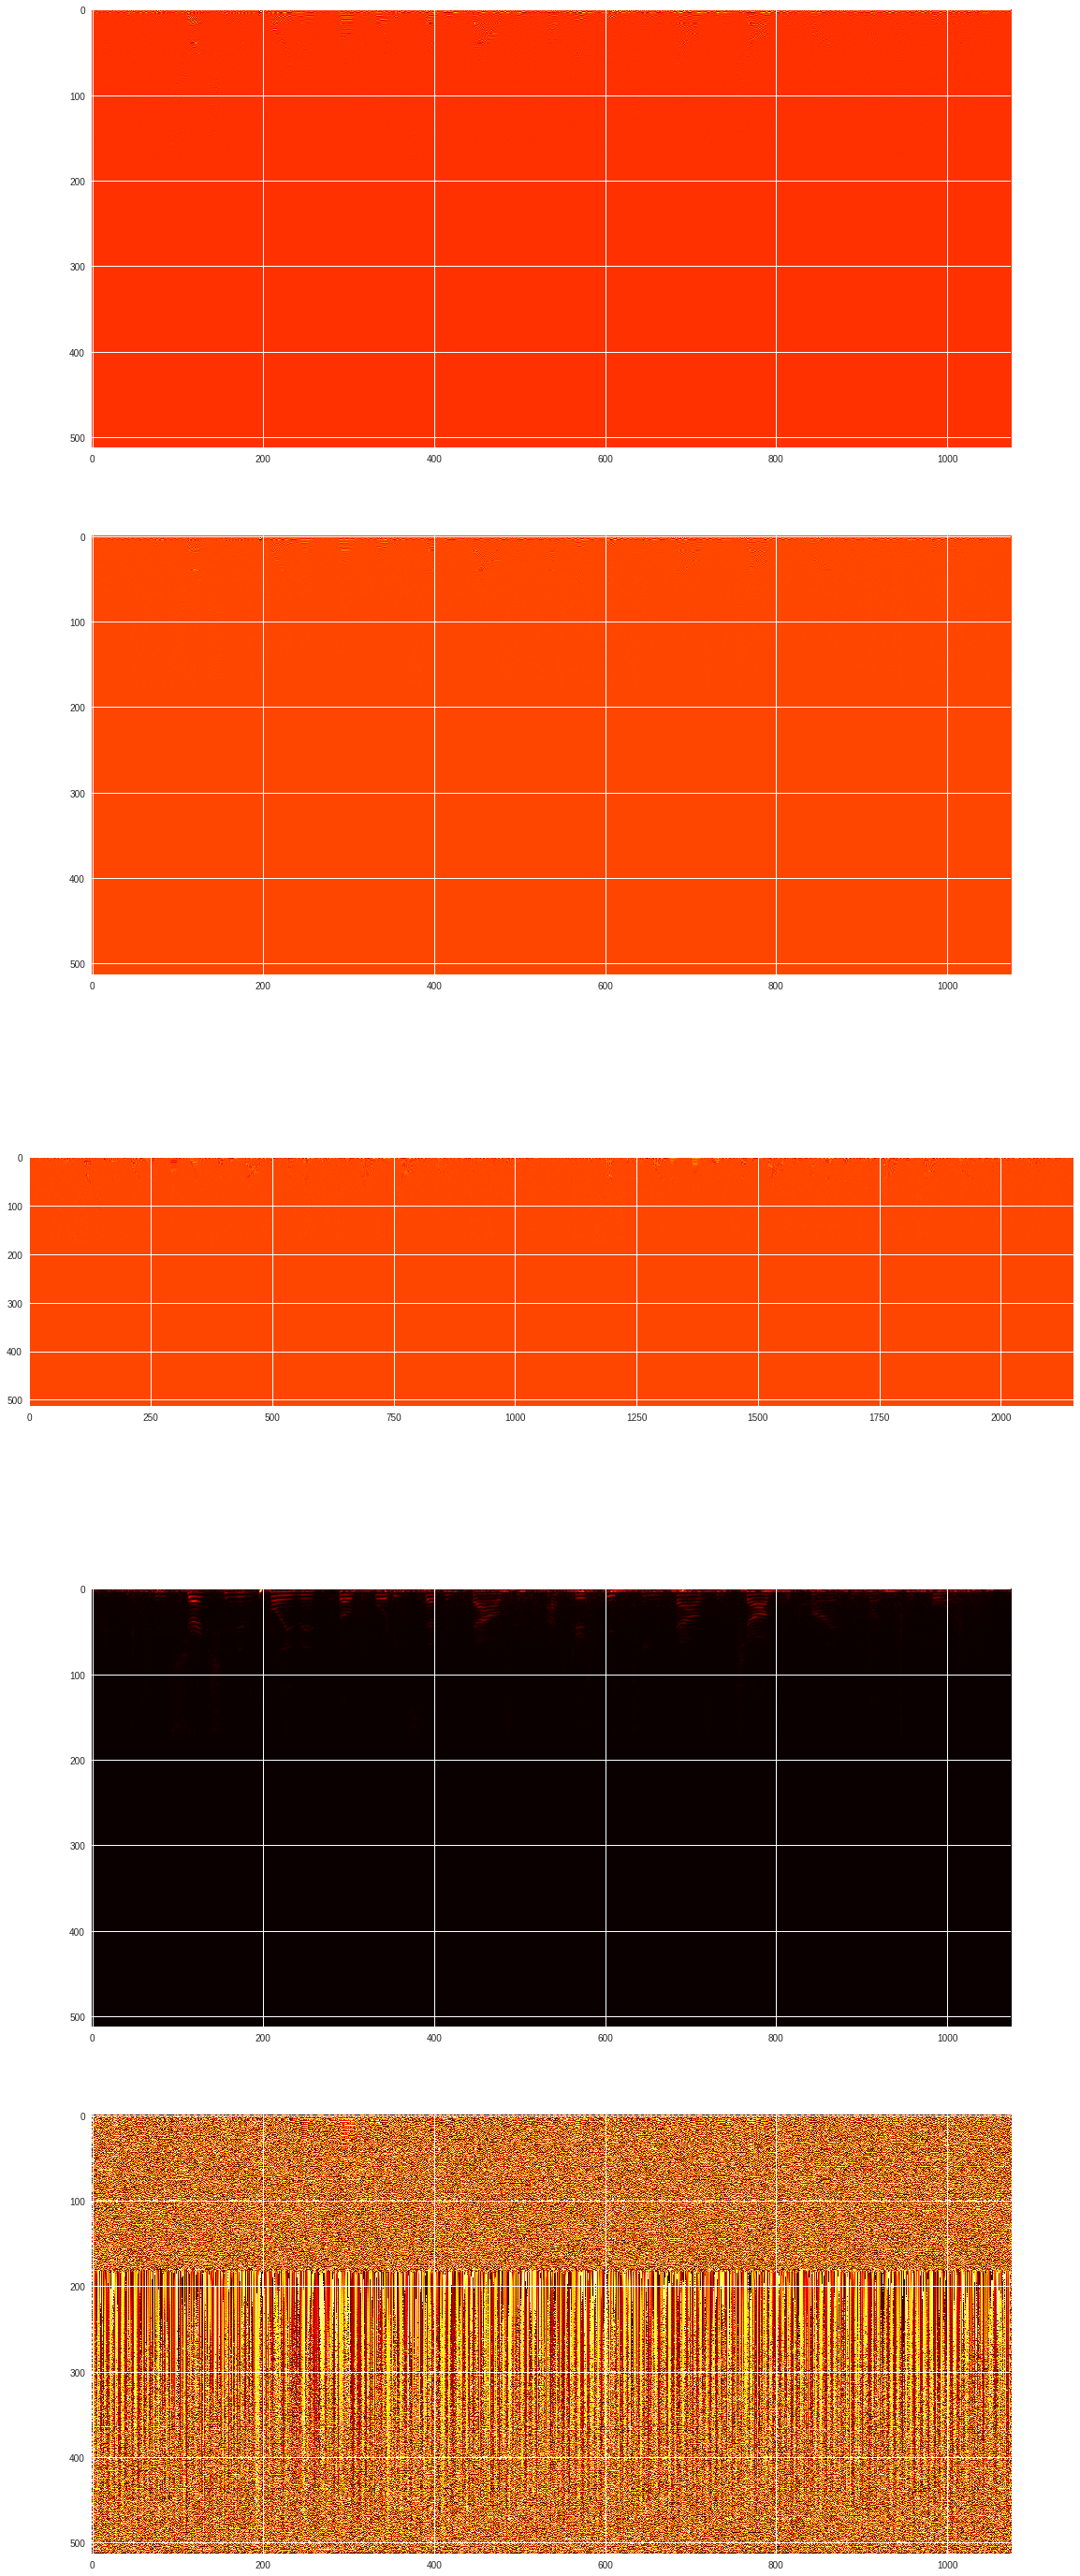

In [21]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1, figsize=(20,50))
ax1.imshow(spec.real)
ax2.imshow(spec.imag)
ax3.imshow(np.concatenate((spec.real, spec.imag), axis=1))
ax4.imshow(mag)
ax5.imshow(np.angle(phase))

In [15]:
spec.imag

array([[ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [-7.8550447e-17, -1.3088802e+00, -2.9936550e+00, ...,
        -5.6192271e-02,  3.2702131e+00, -2.6156247e+00],
       [-5.4868061e-17, -3.0333326e+00,  9.1360015e-01, ...,
         6.4747059e-01, -5.8945789e+00,  2.5305789e+00],
       ...,
       [ 6.5795269e-19, -1.3191314e-07,  6.9831430e-08, ...,
         3.4117225e-08, -9.7708609e-05,  8.5652439e-04],
       [ 7.9688860e-18, -1.3848128e-03, -2.6061585e-08, ...,
         2.8597075e-08, -5.9299706e-05, -7.5035304e-04],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00]], dtype=float32)

In [0]:
spectrogram=spectrogram*norm

spectrogram_r = reverse_extract_spectrogram_patches(voice_spec_pred)
spectrogram_r2 = spectrogram_r[0,:,:,0].T
mag = np.vstack((spectrogram_r2, np.zeros((spectrogram_r2.shape[1]))))
n = phase.shape[1] // 128 * 128
phase = phase[:,:n]
write_wav(f'test.wav', istft(mag*phase, win_length=1024, hop_length=256, window='hann'), 44100, norm=True)

In [0]:
a = np.array([[1, 2], [3, 4]])
b = np.array([[5, 6], [7, 8]])
a = np.expand_dims(a, axis=2)
b = np.expand_dims(b, axis=2)
print(a.shape)
print(b.shape)
print(np.concatenate((a, b), axis=2))

(2, 2, 1)
(2, 2, 1)
[[[1 5]
  [2 6]]

 [[3 7]
  [4 8]]]
